In [71]:
import numpy as np
import pandas as pd
import os
import cv2

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras import models
from keras.layers import Dense
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [72]:
# Create variables for the directory of target files
path_to_csv = "data/screenshot_aqi.csv"
path_to_images = "../ML-AirQuality/screenshots"

# Load the dataframe from csv file
df = pd.read_csv(path_to_csv)

Because of the format of the .csv file (our image name and value corresponds to the same image.png), we can add the values of the .csv to an array wit its corresponding image name.
1. **Iterate through the dataframe rows.** Each row corresponds to an image and its value
2. **Extract Filename and Image path.** The name from the datframe corresponds to the path of the actual image found in this folder. We can construct  a full path to the image by joinging the directory path
3. **Load and resize the image.** This is done to ensure that all the images fed in to the model have a consistent size
4. **Normalize Image Data.** Helps the model converge faster during training
5. **Extract Label.**  The label is extracted from the filename of each image in the folder.
6. **Append to Lists.**

In [73]:
# Load images and labels directly into arrays
images = []
labels = []

for index, row in df.iterrows():
    filename = row['File_Name']
    image_path = os.path.join(path_to_images, filename)
    img = cv2.imread(image_path)  # Use cv2 for image loading
    if img is None:
        print(f"Error: Unable to read the image: {image_path}")
        continue  # Skip to the next iteration
    img = cv2.resize(img, (128, 128))
    img_array = img / 255.0  # Normalize to [0, 1]
    label = row['AQI']
    print(f"Original Image Size: {img.shape}")

    images.append(img_array)
    labels.append(label)

Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)
Original Image Size: (128, 128, 3)


In [74]:
# Convert lists to NumPy arrays
images = np.array(images, dtype = np.float32)
labels = np.array(labels, dtype = np.float32)

In [75]:
# Split the data for training, validation, and testing
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

### Sequential Model
A Sequential model is a linear stack of layers used to build neural networks. It is called 'sequential' because you can think of it as building the model layer by layer in a sequential manner, where the output of one layer becomes the input of the next layer.

- **Linear Stack of Layers:** A Sequential model is a way to create a neural network by adding one layer at a time, in a linear fashion. You start with an empty model and keep adding layers to it.
- **Layers:** Layers are the building blocks of a neural network. Each layer in a Sequential model represents a specific operation or transformation on the data. For example, a 'Dense' layer is a fully connected layer where each neuron is connected to every neuron in the previous and next layers
- **Purpose:** The purpose of a Sequential model is to make it easier to create and understand simple neural networks. It's suitable for a wide range of tasks, from basic to moderately complex problems. However, for more complex architectures with multiple inputs, outputs, or shared layers, you might need to use the Keras functional API.
- **Architecture:** The architecture of a Sequential model is a straightforward stack of layers. The data flows through each layer sequentially, and each layer processes the input it receives from the previous layer. The final layer produces the output of the model.<br>

[Sequential Model Visual](https://daxg39y63pxwu.cloudfront.net/images/blog/deep-learning-algorithms/RBFN_deep_learning_algorithm.png)


Here's an example of a simple Sequential model architecture:<br>
```
Input Layer (e.g., 128x128x3 images)
   |
Convolutional Layer (32 filters, 3x3 kernel, ReLU activation)
   |
Max Pooling Layer (2x2 pool size)
   |
Convolutional Layer (64 filters, 3x3 kernel, ReLU activation)
   |
Max Pooling Layer (2x2 pool size)
   |
Flatten Layer
   |
Dense Layer (128 units, ReLU activation)
   |
Dense Layer (1 unit, output layer)
```

This example represents a Convolutional Neural Network (CNN) for image classification. Each layer contributes to extracting features from the input data, and the final layer produces the model's prediction.


In [76]:
# Define the architecture of the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

import tensorflow as tf
from keras import backend as K

# Define custom metrics
def mse_metric(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return K.clip(r2, 0, 1)

# Compile the model with custom metrics
model.compile(optimizer='adam', loss='huber_loss', metrics=[mse_metric, 'msle', r_square])

# Create the model
# model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae', 'mse_metric', 'msle', 'huber_loss', 'r_square'])


### Early Stopping

In some cases, the model starts to plateau after so many epochs. To be more efficient with time, the EarlyStopping function allows us to stop the model training after a certain range of val_loss

In [77]:
# Callback function applied during training
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [78]:
# Train the model
# Record the information of the model training
history = model.fit(X_train, y_train,
                    epochs = 300,
                    batch_size = 32,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping],
                    verbose = 2)

Epoch 1/300


1/1 - 2s - loss: 78.5296 - mse_metric: 6352.3281 - msle: 18.2270 - r_square: 0.0000e+00 - val_loss: 78.6203 - val_mse_metric: 6260.4390 - val_msle: 9.4973 - val_r_square: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/300
1/1 - 0s - loss: 75.9553 - mse_metric: 5956.5112 - msle: 10.1904 - r_square: 0.0000e+00 - val_loss: 72.1394 - val_mse_metric: 5280.6660 - val_msle: 4.4508 - val_r_square: 0.0000e+00 - 240ms/epoch - 240ms/step
Epoch 3/300
1/1 - 0s - loss: 70.5396 - mse_metric: 5179.9829 - msle: 5.2481 - r_square: 0.0000e+00 - val_loss: 59.5296 - val_mse_metric: 3625.6973 - val_msle: 1.7468 - val_r_square: 0.0000e+00 - 237ms/epoch - 237ms/step
Epoch 4/300
1/1 - 0s - loss: 57.4336 - mse_metric: 3539.5110 - msle: 2.1732 - r_square: 0.0000e+00 - val_loss: 37.1057 - val_mse_metric: 1502.4287 - val_msle: 0.4332 - val_r_square: 0.0000e+00 - 238ms/epoch - 238ms/step
Epoch 5/300
1/1 - 0s - loss: 36.9300 - mse_metric: 1976.2051 - msle: 1.9536 - r_square: 0.0000e+00 - val_loss: 14.2783 - val_mse_metric:

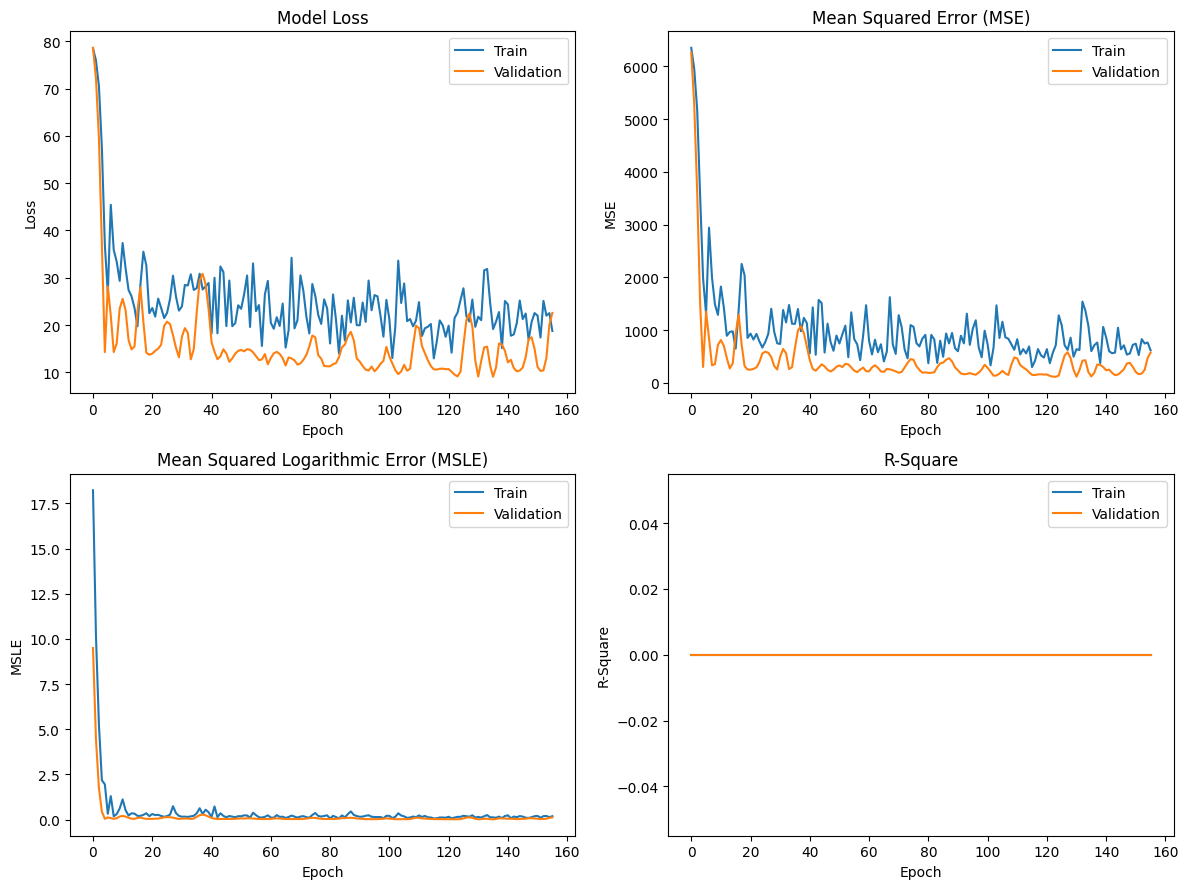

In [79]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 9))

    # Plot training & validation loss values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot custom metric 1 (MSE)
    plt.subplot(2, 2, 2)
    plt.plot(history.history['mse_metric'])
    plt.plot(history.history['val_mse_metric'])
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot custom metric 2 (MSLE)
    plt.subplot(2, 2, 3)
    plt.plot(history.history['msle'])
    plt.plot(history.history['val_msle'])
    plt.title('Mean Squared Logarithmic Error (MSLE)')
    plt.xlabel('Epoch')
    plt.ylabel('MSLE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot custom metric 3 (R-Square)
    plt.subplot(2, 2, 4)
    plt.plot(history.history['r_square'])
    plt.plot(history.history['val_r_square'])
    plt.title('R-Square')
    plt.xlabel('Epoch')
    plt.ylabel('R-Square')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Use this function to plot training history
plot_training_history(history)


